<a href="https://colab.research.google.com/github/Salmasherif33/Simple-Perception-Stack-for-Self-Driving-Cars/blob/main/IMAGE_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLO**

In [ ]:
import requests

URL = "https://pjreddie.com/media/files/yolov3.weights"
response = requests.get(URL)
dest ="yolov3.weights"
with open(dest, "wb") as file_:
    file_.write(response.content)

In [ ]:
from numpy.core.numeric import indices
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Union, Optional
from numpy import ndarray as ARRAY
import cv2
yolov3_cfg_url = 'https://github.com/arunponnusamy/object-detection-opencv/raw/master/yolov3.cfg'
yolov3_weights_url = 'https://pjreddie.com/media/files/yolov3.weights'

def load_yolo(weights_path , cfg_path ,coco_path):
    weights_total = "yolov3.weights"
    cfg_total = cfg_path +  "yolov3.cfg"
    coco_total = coco_path + "coco.names"

    net = cv2.dnn.readNet(weights_total, cfg_total)
    classes = []
    with open(coco_total , "r") as f:
        classes = [line.strip() for line in f.readlines()]

    # classes = ["person", "car", "bus", "truck", "motorbike", "bicycle"]
    # classes = ["person", "car",]
    layer_names = net.getLayerNames()

    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]  
    colors = np.random.uniform(0, 255, size=(len(classes), 3))                      ##non important
    return net ,classes ,output_layers,colors                                       ##Labels


def detect(img,net,output_layers):
    scale = 0.00392
    width, height = img.shape[1], img.shape[0]
    blob = cv2.dnn.blobFromImage(img, scale,(416, 416) , (0, 0, 0), crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                # cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,255), 10)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return class_ids ,boxes , confidences

def vis(img,class_ids, boxes, confidences,classes,colors):
    # eliminate redundant overlapping boxes with conf < 0.5
    confThreshold, nmsThreshold = 0.5, 0.4
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

    bbox = []
    labels = []
    
    for j in indexes:
        j=j[0]
        x, y, w, h = boxes[j]
        bbox.append([int(x), int(y), int(x+w), int(y+h)])
        labels.append(str(classes[class_ids[j]]))   

    return bbox,labels

# **edge detection**

In [ ]:
import sys
import cv2 as cv
import numpy as np
import glob



def gaussian_blur(img, kernel_size):
    return cv.gaussian_blur(img,(kernel_size, kernel_size),0)

#define low and high threshold percentage for the image to make the lanes clearer
def r_threshold(img, th1, th2):
    mini = np.min(img)  #get the minimum pixel value in the image 5
    maxi = np.max(img)  #get the maximum pixel value in the image 200

    low = mini + (maxi- mini)*th1   #the actual threshold value (the lowest)
    high = mini + (maxi - mini)*th2 #the highest

    #convert it to binary image 
    return np.uint8((img >= low) & (img <= high))*255

def l_threshold(img, th1, th2):
    #use the actual threshold value directly
    return np.uint8((img >= th1) & (img <= th2))*255

def grayscale(img):

    #convert img to HLS and HLV scale
    hls = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    h = hls[:, :, 0]

    l = hls[:, :, 1]
    s = hls[:, :, 2]
    v = hsv[:,:,2]

    #use Lightening(L) channel : highlight the right lane more(white lane)
    r_lane = r_threshold(l, 0.75, 2)    
    r_lane[:,:700] = 0  #make the left half of the image == 0
    
    #use H & s channel to helight the left lane(yellow one)
    l_lane = l_threshold(h, 30,100) 
    l_lane &= r_threshold(s, 0.1,1) 
   
   #make the right half of the image == 0 , and the most left part in the imag
    l_lane[:, 700:] = 0
    l_lane[:, :200] = 0

    return ( l_lane | r_lane)   #combine them


#function do like the functionality of canny to detect the edge
def canny(img):
    img = grayscale(img)

    return img


# **bird eye**

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    line_dst_offset = 200   #to bring left/right lines closer to each other (curves)
    width = img.shape[1]
    height = img.shape[0]
   
    src = np.float32(
        [
            [600, 470],  # Top-left corner
            [300, 660],  # Bottom-left corner
            [1050, 684],  # Bottom-right corner
            [725, 470]  # Top-right corner
        ])

    padding = int(0.20 * width)

    dst = np.float32(
        [
            [padding+30,100],                # Top-left corner
            [padding+30,height -10],           # Bottom-left corner
            [width - (padding+113), height],   # Bottom-right corner#
            [width - (padding+113),50]        # Top-right corner
        ])


    M = cv.getPerspectiveTransform(src, dst)
    Minv = cv.getPerspectiveTransform(dst, src)
    
    binary_warped = cv.warpPerspective(img, M, img_size, flags=cv.INTER_LINEAR)


    return binary_warped, Minv

def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    return histogram


#function to draw a red polygon around the lanes in the bird  eye view
def bird_view_markings(img):
    width = img.shape[1]
    height = img.shape[0]
    padding = int(0.20 * width)

    dst = np.float32(
        [
            [padding - 90,10],                # Top-left corner
            [padding-90,height -30],           # Bottom-left corner
            [width - (padding+100), height-30],   # Bottom-right corner#
            [width - (padding+100),10]        # Top-right corner
        ])

 
    detected_plot = cv.polylines(np.copy(img), np.int32([
        dst]), True, (147, 20, 255), 3)

    return detected_plot


def final_bird(img):
    warped , Minv = warp(img)
    histogram = get_histogram(warped)
    img = bird_view_markings(warped)
    ret,thresh1 = cv.threshold(img,0,255,cv.THRESH_BINARY)
    #plt.plot(histogram)
    #plt.show()
    
    return thresh1 , histogram , Minv

# **Window**

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg




## Simple sliding window fn ##

##  (frame , warped image) 
def sliding_window_polyfit(exampleImg,img):
    # Take a histo of the bottom half of the warped img 
    histo = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histo
    # These will be the starting point for the left and right lines
    midpoint = np.int(histo.shape[0]//2)
    quarter_point = np.int(midpoint//2)

    #print ('midpoint = ',midpoint)
    # Previously the left/right base was the max of the left/right half of the histo
    # this changes it so that only a quarter of the histo (directly to the left/right) is considered
    '''
     np.argmax will return the index (x-value) of the max element
     we added a threshold (quarter_point) or (midpoint)
    '''
    #print (np.argmax(histo[quarter_point:midpoint]))
    leftx_base = np.argmax(histo[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histo[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)


    
    window_height = np.int(img.shape[0]/10)     ##window height in pixels ... assuming no. of sliding windows = 10 ##
    # get x & y coordinates for white pixels 
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    

    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_ends = []
    right_lane_ends = []
    # Rectangle data for visualization
    rectangle_data = []

    for window in range(10):
        # Identify window boundaries in x and y (and right and left)
        ## NB: both left and right windows have the same (win_y_low - win_y_high) but different x values
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - 90      ##some marginal fitt to make sure each window alligned same as avg windows##
        win_xleft_high = leftx_current + 90 
        win_xright_low = rightx_current - 90
        win_xright_high = rightx_current + 90
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))


        # Identify the nonzero pixels in x and y within the window
        '''
            by comparing nonzerox and nonzeroy with the sliding window coordinates 
            if the window really contain "any" white pixels we will take it
        '''
        valid_lefts = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        valid_rights = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        ## left_lane_ends = [ [valid_lefts] , [valid_lefts] , [valid_lefts] ,... ]
        left_lane_ends.append(valid_lefts)
        right_lane_ends.append(valid_rights)


        # If you found > minpix pixels, recenter next window on their mean position
        if len(valid_lefts) > minpix:
            leftx_current = np.int(np.mean(nonzerox[valid_lefts]))
        if len(valid_rights) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[valid_rights]))

    # Concatenate the arrays of indices
    left_lane_ends = np.concatenate(left_lane_ends)
    right_lane_ends = np.concatenate(right_lane_ends)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_ends]
    lefty = nonzeroy[left_lane_ends] 
    rightx = nonzerox[right_lane_ends]
    righty = nonzeroy[right_lane_ends] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    

   



    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    for rect in rectangle_data:
    # Draw the windows on the visualization image
        cv.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_ends], nonzerox[left_lane_ends]] = [255, 255, 255]
    out_img[nonzeroy[right_lane_ends], nonzerox[right_lane_ends]] = [255, 255, 255]
    return left_fit, right_fit, left_lane_ends, right_lane_ends , out_img,ploty, leftx, lefty,rightx,righty


# **lane detection**

In [ ]:

import matplotlib.image as mpimg



#function to draw a red polygon around the lanes in the normal view
def lane_line_markings(img):
    src = np.float32(
        [
            (570, 490),  # Top-left corner
            (350, 660),  # Bottom-left corner
            (1100, 684),  # Bottom-right corner
            (740, 480)  # Top-right corner
        ])

    """   (572, 454),  # Top-left corner
            (330, 660),  # Bottom-left corner
            (1100, 684),  # Bottom-right corner
            (690, 454)  # Top-right corner """

    detected_plot = cv.polylines(np.copy(img), np.int32([
        src]), True, (147, 20, 255), 3)

    return detected_plot


def bird_draw_lane(binary_img, l_fit, r_fit):
    new_img = np.copy(binary_img)
    if l_fit is None or r_fit is None:
        return binary_img
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv.fillPoly(color_warp, np.int_([pts]), (255,255, 0))
    cv.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=15)
    cv.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
    return color_warp


def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    #temp = binary_img[200:700  , 180:1200]
    #binary_img = cv.matchTemplate(binary_img,temp,cv.TM_CCOEFF_NORMED)
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    ## Draw the using poly lines ##

    cv.fillPoly(color_warp, np.int_([pts]), (255,255, 0))
    cv.polylines(color_warp,np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=15)
    cv.polylines(color_warp,np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)

    # Warp perspective using given using Minv 
    newwarp = cv.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

# **last overlay**

In [ ]:
def rescale(img,scale):
    w = int (img.shape[1]*scale)
    h = int(img.shape[0]*scale)
    dimensions = (w,h)

    return cv.resize(img,dimensions, interpolation=cv.INTER_AREA)

def last_overlay(left_curvem,right_curvem, text2 , img , bbox , labels ,colors):
    origin1 = (50,50)
    origin2 = (50,100)
    font = cv.FONT_HERSHEY_SIMPLEX
    fonts = 1
    thick = 3
    color = (255,255,255)
    text1 = 'Radius of Curvature = '
    text1 += str((left_curvem+right_curvem)/2)[:7]+' m'

    img = cv.putText(img , text1 , origin1, font , fonts , color , thick)
    img = cv.putText(img , text2 , origin2, font , fonts , color , thick)
    for i, label in enumerate(labels):
        color = colors[i]
        cv.rectangle(img, (bbox[i][0],bbox[i][1]), (bbox[i][2],bbox[i][3]), color, 2)
        cv.putText(img, label, (bbox[i][0],bbox[i][1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img


def debug_overlay(img , left_curvem,right_curvem,text2,bird_draw,slid_out,warped,lane_markings,bbox,labels,colors):

    ## darkening background 
    mask = cv.rectangle(np.copy(img), (0, 0), (img.shape[1], 220), (0, 0, 0), thickness=cv.FILLED)
    img = cv.addWeighted(src1=mask, alpha=0.3, src2=img, beta=0.8, gamma=0)


    origin1 = (20,190)
    origin2 = (20,210)
    font = cv.FONT_HERSHEY_SIMPLEX
    fonts = 0.5
    thick = 1
    color = (255,255,255)
    text1 = 'Radius of Curvature = '
    text1 += str((left_curvem+right_curvem)/2)[:7]+' m'

    img = cv.putText(img , text1 , origin1, font , fonts , color , thick)
    img = cv.putText(img , text2 , origin2, font , fonts , color , thick)
    bird_draw = rescale(bird_draw, 0.2)
    x_offset= int(img.shape[0]) + 40
    y_offset=5
    img [5:5+50 , 200:200+20 ]
    img[y_offset:y_offset+bird_draw.shape[0], x_offset:x_offset+bird_draw.shape[1]] = bird_draw



    slid_out = rescale(slid_out, 0.2)
    x_offset= int(img.shape[0]) + 300
    y_offset=5
    img[y_offset:y_offset+slid_out.shape[0], x_offset:x_offset+slid_out.shape[1]] = slid_out

    warped =  cv.cvtColor(warped,cv.COLOR_GRAY2BGR)
    warped = rescale(warped, 0.2)
    x_offset= int(img.shape[0]) + 300
    y_offset=150
    img[y_offset:y_offset+warped.shape[0], x_offset:x_offset+warped.shape[1]] = warped


  
    lane_markings = rescale(lane_markings, 0.2)
    x_offset= int(img.shape[0]) + 40
    y_offset=150
    img[y_offset:y_offset+lane_markings.shape[0], x_offset:x_offset+lane_markings.shape[1]] = lane_markings


    for i, label in enumerate(labels):
        color = colors[i]
        thumbnail = cv.rectangle(img, (bbox[i][0],bbox[i][1]), (bbox[i][2],bbox[i][3]), color, 2)
        cv.putText(img, label, (bbox[i][0],bbox[i][1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


    thumb_w=100 
    thumb_h=80
    off_x=10
    off_y=30
    ##([x, y, w, h])
    #int(x), int(y), int(x+w), int(y+h)
    #     0,0  0,1     1,0  1,1
    ## [ [ x-w,y-h]  [ x+w,y+h] ] 
    cv.putText(img, 'Detected Vehicles', (20,37), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, cv.LINE_AA)
    if bbox:
        for i, bbox in enumerate(bbox):
            thumbnail = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] 
            if thumbnail.any():
                vehicle_thumb = cv.resize(thumbnail, dsize=(thumb_w, thumb_h))
                start_x = 50 + (i+1) * off_x + i * thumb_w
                img[off_y + 30:off_y + thumb_h + 30, start_x:start_x + thumb_w, :] = vehicle_thumb

    return img

# **calculations**

In [ ]:
def center(img , left_fit,right_fit,left_lane_inds, right_lane_inds):
  
  
    ## vehicle
    offset = "Vehicle is "
    if right_fit is not None and left_fit is not None:
        h = img.shape[0]
        w = img.shape[1]
        car_midpoint = w/2    #dividing width by 2 to get the center of img

        
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_midpoint = (right_fit_x_int + left_fit_x_int) /2
        center_offset = (car_midpoint - lane_midpoint) * (3.7/378) 
        center_offset = round(center_offset, 4)
        offset += str(center_offset) + "m from the center"
    
    lane_distance = left_fit - right_fit
    return offset

def calculate_curvature(ploty,leftx,lefty,rightx,righty):

    y_eval = np.max(ploty)
    ym = 10.0 / 600 # assumption --> each 60 pixel = 1 m 
    xm = 3.7 / 781 

    # Fit polynomial curves to the real world environment
    left_fit_cr = np.polyfit(lefty * ym, leftx * (xm), 2)
    right_fit_cr = np.polyfit(righty * ym, rightx * (xm), 2)

    # Calculate the radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*ym + left_fit_cr[
                    1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[
                    0]*y_eval*ym + right_fit_cr[
                    1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curvem, right_curvem

# **MAIN**

test5.jpg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

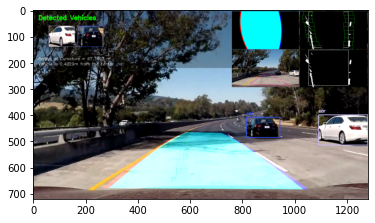

In [ ]:
type_ = "img"
path = "/content/drive/MyDrive/image_processing/test5.jpg"
destination = "/content/challenge_output.mp4"
mode = 1 ## debug mode


if(type_ == "vid"):
    capture = cv.VideoCapture(path)
    i = 0
    istrue, frame = capture.read()      #istrue = true if there is a frame
    height, width, layers = frame.shape
    size = (width,height)
    out = cv.VideoWriter(destination,cv.VideoWriter_fourcc(*"mp4v"), 25, size)  
    img_array = []
    load_path = "/content/drive/MyDrive/image_processing/"
    net ,classes ,output_layers,colors = load_yolo(load_path, load_path ,load_path)

    c = 0
    
    while istrue:
        if c % 5 == 0:
          c+=1
          istrue, frame = capture.read()
          continue
        output_img = canny(frame)
        warped,histogram,Minv = final_bird(output_img)
        left_fit,right_fit,left_lane_ends, right_lane_ends, slid_out, ploty,leftx,lefty,rightx,righty =sliding_window_polyfit(frame,warped)
        bird_draw = bird_draw_lane(warped,left_fit,right_fit)
        result = draw_lane(frame,output_img,left_fit,right_fit,Minv)   
        offset = center(warped , left_fit,right_fit,left_lane_ends,right_lane_ends)
        lane_markings = lane_line_markings(frame)
        left_curvem,right_curvem = calculate_curvature(ploty,leftx,lefty,rightx,righty)
        c+=1
        # YOLO
        class_ids , boxes , confidences  = detect(frame,net,output_layers)
        bbox,labels  =  vis(frame,class_ids , boxes, confidences,classes,colors)
        if(mode == 1):
            result = debug_overlay(result,bird_draw,slid_out,warped,lane_markings,bbox,labels,colors)
        elif (mode ==0):
            result = last_overlay(left_curvem,right_curvem, offset,result,bbox,labels,colors)
        else:
            print("ERROR:No valid debug_mode was given")
            break
        out.write(result)
        #cv.imshow('Output_Video',result)
        istrue, frame = capture.read() 
    out.release()

elif (type_ == "img"):
        img =  cv.imread(path)
        output_img = canny(img)
        warped,histogram,Minv = final_bird(output_img)
        left_fit,right_fit,left_lane_ends, right_lane_ends, slid_out, ploty,leftx,lefty,rightx,righty =sliding_window_polyfit(img,warped)
        bird_draw = bird_draw_lane(warped,left_fit,right_fit)
        result = draw_lane(img,output_img,left_fit,right_fit,Minv)     
        offset = center(warped , left_fit,right_fit,left_lane_ends,right_lane_ends)
        lane_markings = lane_line_markings(img)
        left_curvem,right_curvem = calculate_curvature(ploty,leftx,lefty,rightx,righty)
        ##YOLO
        
        load_path = "/content/drive/MyDrive/image_processing/"
        net ,classes ,output_layers,colors = load_yolo(load_path, load_path ,load_path)
        class_ids , boxes , confidences  = detect(img,net,output_layers)

        
        bbox,labels  =  vis(img,class_ids , boxes, confidences,classes,colors)
        
        if(mode == 1):
            result = debug_overlay(result,left_curvem,right_curvem,offset,bird_draw,slid_out,warped,lane_markings,bbox,labels,colors)
        elif (mode ==0):
            result = last_overlay(left_curvem,right_curvem, offset,result,bbox,labels,colors)
        else:
            print("ERROR:No valid debug_mode was given")
        plt.imshow(result[:, :, ::-1])





test4.jpg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

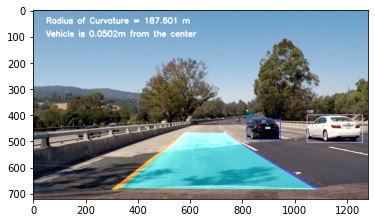

In [ ]:
type_ = "img"
path = "/content/drive/MyDrive/image_processing/test4.jpg"
destination = "/content/challenge_output.mp4"
mode = 0 ## final mode

img =  cv.imread(path)
output_img = canny(img)
warped,histogram,Minv = final_bird(output_img)
left_fit,right_fit,left_lane_ends, right_lane_ends, slid_out, ploty,leftx,lefty,rightx,righty =sliding_window_polyfit(img,warped)
bird_draw = bird_draw_lane(warped,left_fit,right_fit)
result = draw_lane(img,output_img,left_fit,right_fit,Minv)     
offset = center(warped , left_fit,right_fit,left_lane_ends,right_lane_ends)
lane_markings = lane_line_markings(img)
left_curvem,right_curvem = calculate_curvature(ploty,leftx,lefty,rightx,righty)
##YOLO

class_ids , boxes , confidences  = detect(img,net,output_layers)
bbox,labels  =  vis(img,class_ids , boxes, confidences,classes,colors)

if(mode == 1):
    result = debug_overlay(result,bird_draw,slid_out,warped,lane_markings,bbox,labels,colors)
elif (mode ==0):
    result = last_overlay(left_curvem,right_curvem, offset,result,bbox,labels,colors)
else:
    print("ERROR:No valid debug_mode was given")
plt.imshow(result[:, :, ::-1])